In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
from scipy import special, integrate
import os
import sys

sys.path.insert(0, '/work/08811/aew492/ls6/small-scale_cross-corrs')
from illustris_sim import TNGSim
import corrfuncs
import tools

### functions

In [3]:
def construct_photometric_sample(gal_pos_spec, dx, boxsize, mean=0.):
    gal_pos_phot = []
    for i, pos in enumerate(gal_pos_spec):
        draw = tools.eval_Gaussian(pos[2], dx, mean=mean) * dx.unit
        if draw > np.random.uniform():
            gal_pos_phot.append(pos)
        else:
            continue
    return np.array(gal_pos_phot) << dx.unit

In [4]:
def photxspec(gal_pos_spec, redshift, sigma_z, boxsize, nslices=11, nbins=10, thetamin=.001, thetamax=5.):
    
    # prep inputs
    gal_pos_spec = gal_pos_spec.to(u.Mpc/cu.littleh) if isinstance(gal_pos_spec, u.Quantity) \
                    else gal_pos_spec * u.Mpc/cu.littleh
    boxsize = boxsize.to(u.Mpc/cu.littleh) if isinstance(boxsize, u.Quantity) else boxsize * u.Mpc/cu.littleh
    # width of Gaussian for constructing the photometric sample
    dx = tools.get_dx(redshift, sigma_z).to(boxsize.unit)
    # comoving distance to the box center
    r = tools.redshift_to_comov(redshift).to(dx.unit)
    # separation bins
    bins = np.logspace(np.log10(thetamin), np.log10(thetamax), nbins+1)
    
    # divide into narrow 2D slices along the LOS
    losbins = np.linspace(-boxsize.value/2, boxsize.value/2, nslices+1)
    slicewidth = (losbins[1]-losbins[0])
    slice_centers = np.array([(losbins[i]+losbins[i+1])/2 for i in range(nslices)])
    
    # create nslices samples by shifting and wrapping the LOS positions around the box
    gal_pos_specs = np.empty((nslices, len(gal_pos_spec), 3))
    for i in range(nslices):
        # first, shift everything by i * slicewidth
        gal_pos_spec_ = np.copy(gal_pos_spec)
        gal_pos_spec_[:,2] += i * slicewidth << gal_pos_spec_.unit
        # wrap any galaxies outside the box
        idx_to_wrap = (gal_pos_spec_[:,2] >= boxsize / 2)
        gal_pos_spec_[:,2][idx_to_wrap] -= boxsize
        gal_pos_specs[i] = gal_pos_spec_
        
    gal_pos_phots = [
        construct_photometric_sample(gal_pos_spec_ << dx.unit, dx, boxsize) for gal_pos_spec_ in gal_pos_specs
    ]

    # compute the cross correlation in each slice in each sample and take the average to reduce noise
    xcorrs_PHs = np.empty((nslices, nslices, nbins))
    for i, spec_sample in enumerate(gal_pos_specs):
        # divide the spectroscopic sample and corresponding photometric sample into slices
        slices_spec = [
            spec_sample[(losbins[i] <= spec_sample[:,2]) & (spec_sample[:,2] < losbins[i+1])] \
            for i in range(nslices)
        ]
        # convert photometric sample to (RA,Dec), setting LOS positions to box center
        phot_sample = np.copy(gal_pos_phots[i].value)
        phot_sample[:,2] = 0
        ra_phot, dec_phot = tools.CartesiantoEquatorial(phot_sample, observer=[0.,0.,r.value])
        # random sample
        nd1 = len(ra_phot)
        ra_rand_phot = np.random.uniform(min(ra_phot), max(ra_phot), nd1)
        dec_rand_phot = np.random.uniform(min(dec_phot), max(dec_phot), nd1)

        for j, spec_slice in enumerate(slices_spec):
            # prep spectroscopic slice and corresponding random set
            nd2 = len(spec_slice)
            gal_pos_ = np.copy(spec_slice)
            gal_pos_[:,2] = 0
            ra_spec_, dec_spec_ = tools.CartesiantoEquatorial(gal_pos_, observer=[0.,0.,r.value])

            # compute xcorr
            thetaavg, xcorrs_PHs[i,j] = corrfuncs.wtheta_cross_PH(ra_phot, dec_phot, ra_spec_, dec_spec_,
                                              ra_rand_phot, dec_rand_phot, bins)
            
    res = {
        'dx' : dx,
        'thetaavg' : thetaavg,
        'xcorrs': np.mean(xcorrs_PHs, axis=0),
        'slice_centers' : slice_centers,
        'losbins' : losbins,
        'gal_pos_specs' : gal_pos_specs,
        'gal_pos_phots' : gal_pos_phots
    }
    return res

In [5]:
def get_photometric_weights(gal_pos_phot, boxsize, nslices=11):
    L = boxsize.value if isinstance(boxsize, u.Quantity) else boxsize
    losbins = np.linspace(-L/2, L/2, nslices+1) << u.Mpc / cu.littleh
    slicewidth = (losbins[1]-losbins[0]) << u.Mpc / cu.littleh
    slice_centers = np.array([(losbins[i].value+losbins[i+1].value)/2 for i in range(nslices)]) << u.Mpc / cu.littleh
    
    # photometric
    slices_phot = [
        gal_pos_phot[(losbins[i] <= gal_pos_phot[:,2]) & (gal_pos_phot[:,2] < losbins[i+1])] \
        for i in range(nslices)
    ]
    Nphot = len(gal_pos_phot)
    dNdchi = np.array([len(x) for x in slices_phot]) / slicewidth
    W_phot = 1 / Nphot * dNdchi
    
    return W_phot

In [6]:
def wlin(theta, ell, Cell):
    
    assert ell.ndim == Cell.ndim == 1

    # function of ell that we want to integrate
    def ell_func(ell_, Cell_):
        return (ell_ / (2 * np.pi)) * Cell_ * (special.jv(0, ell_ * theta))

    # construct our array, and integrate using trapezoid rule
    ell_func_arr = np.array([
        ell / (2 * np.pi) * Cell * special.jv(0, ell * theta)
    ]).flatten()
    trapz = integrate.trapz(ell_func_arr, x=ell)

    return trapz, ell_func_arr

### construct samples and compute cross-correlation

In [7]:
# initialize simulation
redshift = 0.5
sim = TNGSim('TNG300-3', redshift=redshift)
sigma_zs = [0.003, 0.01, 0.03, 0.1, 0.2]  # 5 redshift error bins in SPHEREx

In [8]:
%%time
dxs = []
xcorrs = []
gal_pos_specs = []
gal_pos_phots = []
for i, sigma_z in enumerate(sigma_zs):
    print(sigma_z)
    # spectroscopic sample
    gal_pos_spec = sim.subhalo_pos()[sim.gal_idx('','SPHEREx', sigma_z=sigma_z, verbose=True)]
    gal_pos_spec -= sim.boxsize / 2
    gal_pos_specs.append(gal_pos_spec)

    res = photxspec(gal_pos_spec, redshift, sigma_z, sim.boxsize, nslices=11,
                                 nbins=10, thetamin=0.001, thetamax=5.)
    dxs.append(res['dx'])
    xcorrs.append(res['xcorrs'])
    gal_pos_phots.append(res['gal_pos_phots'][0])

0.003
 number density for SPHEREx at z=0.5: 5.01e-04 (h/Mpc)^3 
target number of subhalos: 4316
0.01
 number density for SPHEREx at z=0.5: 2.82e-03 (h/Mpc)^3 
target number of subhalos: 24294
0.03
 number density for SPHEREx at z=0.5: 3.62e-03 (h/Mpc)^3 
target number of subhalos: 31186
0.1
 number density for SPHEREx at z=0.5: 5.35e-03 (h/Mpc)^3 
target number of subhalos: 46090
0.2
 number density for SPHEREx at z=0.5: 3.27e-03 (h/Mpc)^3 
target number of subhalos: 28171
CPU times: user 15min 30s, sys: 1.03 s, total: 15min 31s
Wall time: 7min 37s


In [9]:
thetaavg = res['thetaavg']
slice_centers = res['slice_centers']

In [10]:
thetaavg

array([1.67183646e-03, 3.91823781e-03, 9.18306783e-03, 2.15221073e-02,
       5.04407799e-02, 1.18216689e-01, 2.77061253e-01, 6.49340953e-01,
       1.52184280e+00, 3.56670175e+00])

Text(0.5, 1.05, '$w(\\theta)$ cross-corr, phot. sample x spec. slices, z=0.5')

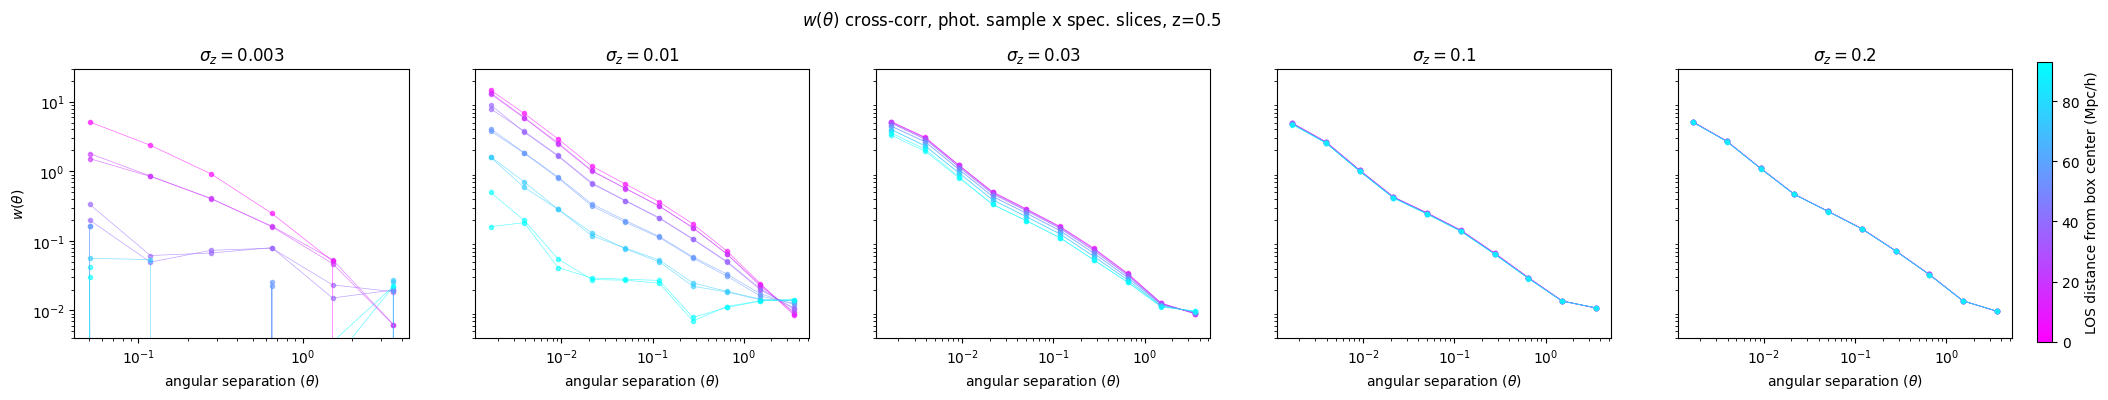

In [11]:
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(cmap='cool_r', norm=norm)

fig = plt.figure(figsize=(25,3.5))
axs = {}

for i, xcorr in enumerate(xcorrs):
    axs[i] = fig.add_subplot(1,5,i+1)

    for j, xcorr_slice in enumerate(xcorr):
        axs[i].plot(thetaavg, xcorr_slice, marker='.', ls='-', lw=0.5, alpha=0.6, c=smap.to_rgba(np.abs(slice_centers[j])))

    axs[i].set_xlabel(r'angular separation ($\theta$)')
    axs[i].set_ylim(4e-3,3e1)
    axs[i].loglog()
    axs[i].set_title(r'$\sigma_z=$'+f'{sigma_zs[i]}')
    if i > 0:
        axs[i].set_yticks([])

axs[0].set_ylabel(r'$w(\theta)$')
cax = fig.add_axes([.91, 0.1, 0.006, 0.8])
fig.colorbar(smap, cax=cax, aspect=100, label='LOS distance from box center (Mpc/h)')
fig.suptitle(r'$w(\theta)$ cross-corr, phot. sample x spec. slices, 'f'z={redshift}', y=1.05)
# fig.tight_layout()

### ratio of clustering amplitudes

In [12]:
def get_ratios(gal_pos_phot, losbins):
    slices_phot = [
        gal_pos_phot[(losbins[i] <= gal_pos_phot[:,2].value) & (gal_pos_phot[:,2].value < losbins[i+1])] \
        for i in range(len(losbins)-1)
    ]
    Ns = np.array([len(x) for x in slices_phot])
    return Ns / max(Ns)

In [13]:
# take the first photometric rlz from each redshift uncertainty sample:
losbins = np.linspace(-sim.boxsize.value/2, sim.boxsize.value/2, 12)
ratios = np.array([
    get_ratios(gal_pos_phot, losbins) for i, gal_pos_phot in enumerate(gal_pos_phots)
])

In [14]:
ravg = thetaavg * u.deg * cosmo.kpc_comoving_per_arcmin(redshift).to(u.Mpc/u.deg) * tools.perh()
ravg

<Quantity [3.84557479e-02, 9.01276945e-02, 2.11229836e-01, 4.95053645e-01,
           1.16024382e+00, 2.71923201e+00, 6.37299040e+00, 1.49362050e+01,
           3.50055790e+01, 8.20416272e+01] Mpc / littleh>

In [15]:
def theta_to_r_comov_(theta):
    return tools.theta_to_r_comov(theta, redshift)
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, redshift)

In [16]:
dxs

[<Quantity 10.24496655 Mpc / littleh>,
 <Quantity 34.14988849 Mpc / littleh>,
 <Quantity 102.44966547 Mpc / littleh>,
 <Quantity 341.49888489 Mpc / littleh>,
 <Quantity 682.99776977 Mpc / littleh>]

Text(0.5, 1.05, '$w(\\theta)$ cross-corr, photometric sample x spectroscopic slices, z=0.5')

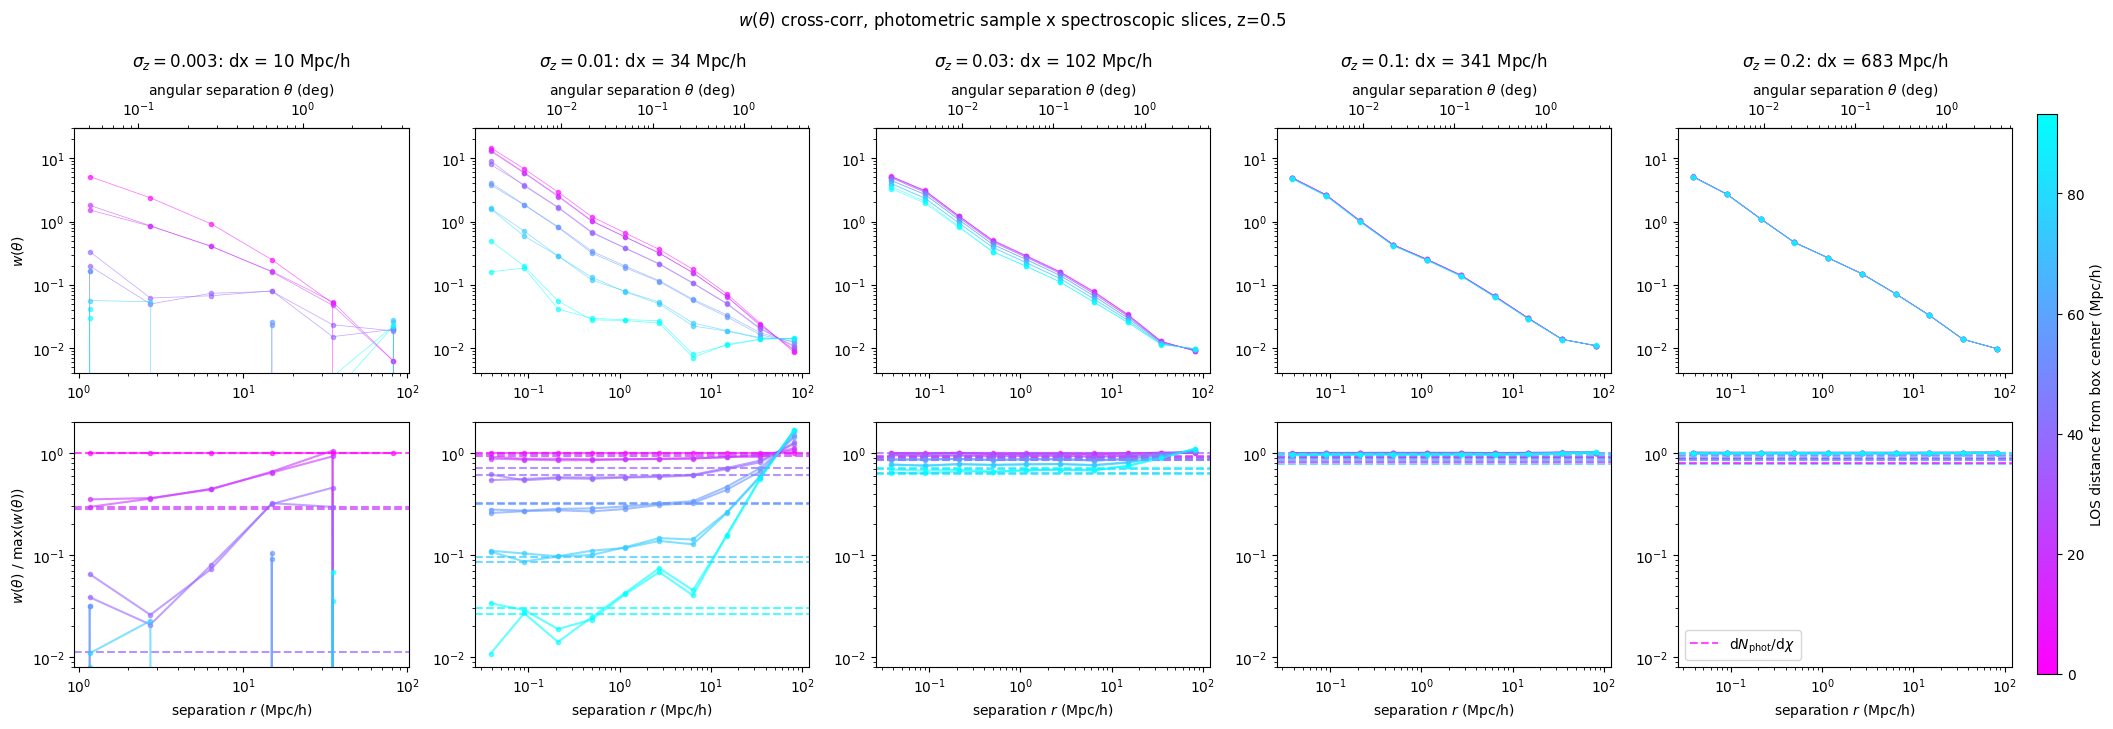

In [17]:
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(cmap='cool_r', norm=norm)

fig = plt.figure(figsize=(25,7))
axs = {}

for i, xcorr in enumerate(xcorrs):
    axs[i] = fig.add_subplot(2,5,i+1)
    for j, xcorr_slice in enumerate(xcorr):
        axs[i].plot(ravg, xcorr_slice, marker='.', ls='-', lw=0.5, alpha=0.6, c=smap.to_rgba(np.abs(slice_centers[j])))
    secax = axs[i].secondary_xaxis('top', functions=(r_comov_to_theta_, theta_to_r_comov_))
    secax.set_xlabel(r'angular separation $\theta$ (deg)')
    axs[i].set_title(r'$\sigma_z=$'+f'{sigma_zs[i]}: dx = {dxs[i].value:.0f} Mpc/h', y=1.22)
    axs[i].set_ylim(4e-3,3e1)
    axs[i].loglog()
    if i == 0:
        axs[i].set_ylabel(r'$w(\theta)$')
for i, xcorr in enumerate(xcorrs):
    axs[i] = fig.add_subplot(2,5,i+6)
    
    # normalize each curve by the c.f. at the box center
    xcorr_center = xcorr[len(xcorr)//2]
    
    for j, xcorr_slice in enumerate(xcorr):
        axs[i].plot(ravg, xcorr_slice / xcorr_center, marker='.', ls='-', alpha=0.6,
                c=smap.to_rgba(np.abs(slice_centers[j])))
        label = r'd$N_\mathrm{phot}$/d$\chi$' if (i==4) and (j==5) else ''
        axs[i].axhline(ratios[i,j], marker='None', ls='--', alpha=0.7,
                       c=smap.to_rgba(np.abs(slice_centers[j])), label=label)
    axs[i].set_xlabel(r'separation $r$ (Mpc/h)')
    if i == 0:
        axs[i].set_ylabel(r'$w(\theta)$ / max$(w(\theta))$')
    if i == 4:
        axs[i].legend()
    axs[i].set_ylim(8e-3, 2)
    axs[i].loglog()

cax = fig.add_axes([.91, 0.1, 0.008, 0.8])
fig.colorbar(smap, cax=cax, aspect=100, label='LOS distance from box center (Mpc/h)')
fig.suptitle(r'$w(\theta)$ cross-corr, photometric sample x spectroscopic slices, 'f'z={redshift}', y=1.05)

### compare to linear theory

In [18]:
# linear matter power spectrum:
r = tools.redshift_to_comov(redshift)  # comoving distance to the box center
ell = np.logspace(0, 6, 1000)  # multipoles

In [19]:
def ell_to_k(ell):
    return (ell + 0.5) / r.value
def k_to_ell(k):
    return (k * r.value) - 0.5

In [20]:
# power spectrum from colossus
colcosmo = cosmology.setCosmology('planck15')
P = colcosmo.matterPowerSpectrum(ell_to_k(ell), redshift)

In [21]:
# bias: Gal x DM / linear theory
dm_pos = tools.get_subsample(sim.dm_pos(), nx=500)  # underlying dark matter
L = sim.boxsize.value
rand_pos = np.random.uniform(-L/2, L/2, (len(dm_pos),3)) # corresponding random set

In [22]:
# separation bins
nbins = 20
r_edges = np.logspace(np.log10(1), np.log10(100.), nbins+1)

0.003


AssertionError: 

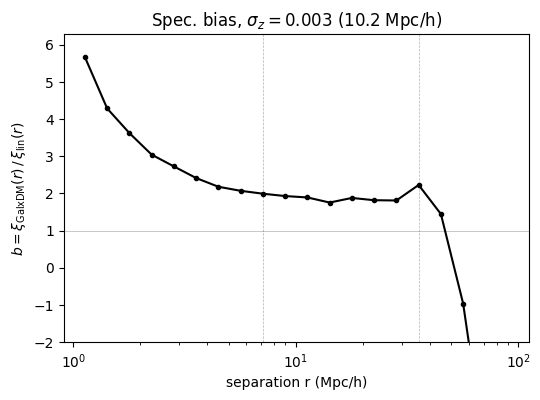

In [29]:
wlin_preds = []
for i, xcorrs_ in enumerate(xcorrs):
    print(sigma_zs[i])
    # spectroscopic x DM
    # shift all positions to 0-L to meet Corrfunc input requirements
    d1 = gal_pos_specs[i].value + L/2
    d2 = dm_pos.value
    r2 = rand_pos + L/2
    assert 0 <= np.all(d1) <= L
    assert 0 <= np.all(d2) <= L
    assert 0 <= np.all(r2) <= L
    ravg, xix_spec = corrfuncs.xi_cross(d1, d2, r2, r_edges, boxsize=L, dtype=float)

    # linear theory from Colossus
    xi_lin = tools.linear_2pcf(redshift, ravg)
    
    # bias
    bs_spec = xix_spec / xi_lin
    
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(ravg, bs_spec, 'k.-')
    ax.axhline(1., c='k', lw=0.5, alpha=0.3)
    ax.axvline(ravg[8], ls='--', c='k', lw=0.5, alpha=0.3)
    ax.axvline(ravg[-5], ls='--', c='k', lw=0.5, alpha=0.3)
    ax.set_xscale('log')
    ax.set_ylim(-2,None)
    ax.set_ylabel(r'$b=\xi_\mathrm{Gal x DM}(r)\,/\,\xi_\mathrm{lin}(r)$')
    ax.set_xlabel('separation r (Mpc/h)')
    ax.set_title(r'Spec. bias, $\sigma_z=$'f'{sigma_zs[i]} ({dxs[i].value:.1f} Mpc/h)')
    
    assert False
    
    b_spec = np.nanmean(bs_spec[8:-5])
    print(f"bias = {b_spec:.3f}")
    
    nslices = 11
    W_phot = get_photometric_weights(gal_pos_phots[i], boxsize=L, nslices=nslices)
    # linear angular power spectrum
    prefactor = 1 / r**2 * b_spec**2 * P
    C_ells = np.array([
        prefactor * W_phot[i] for i in range(nslices)
    ])

    wlin_pred = np.zeros((nslices,len(thetaavg)))
    for i, Cell in enumerate(C_ells):
        wlin_pred[i] = np.array([
            wlin(theta_, ell, Cell)[0] for theta_ in np.deg2rad(thetaavg)
        ])
    wlin_preds.append(wlin_pred)
wlin_preds = np.array(wlin_preds)

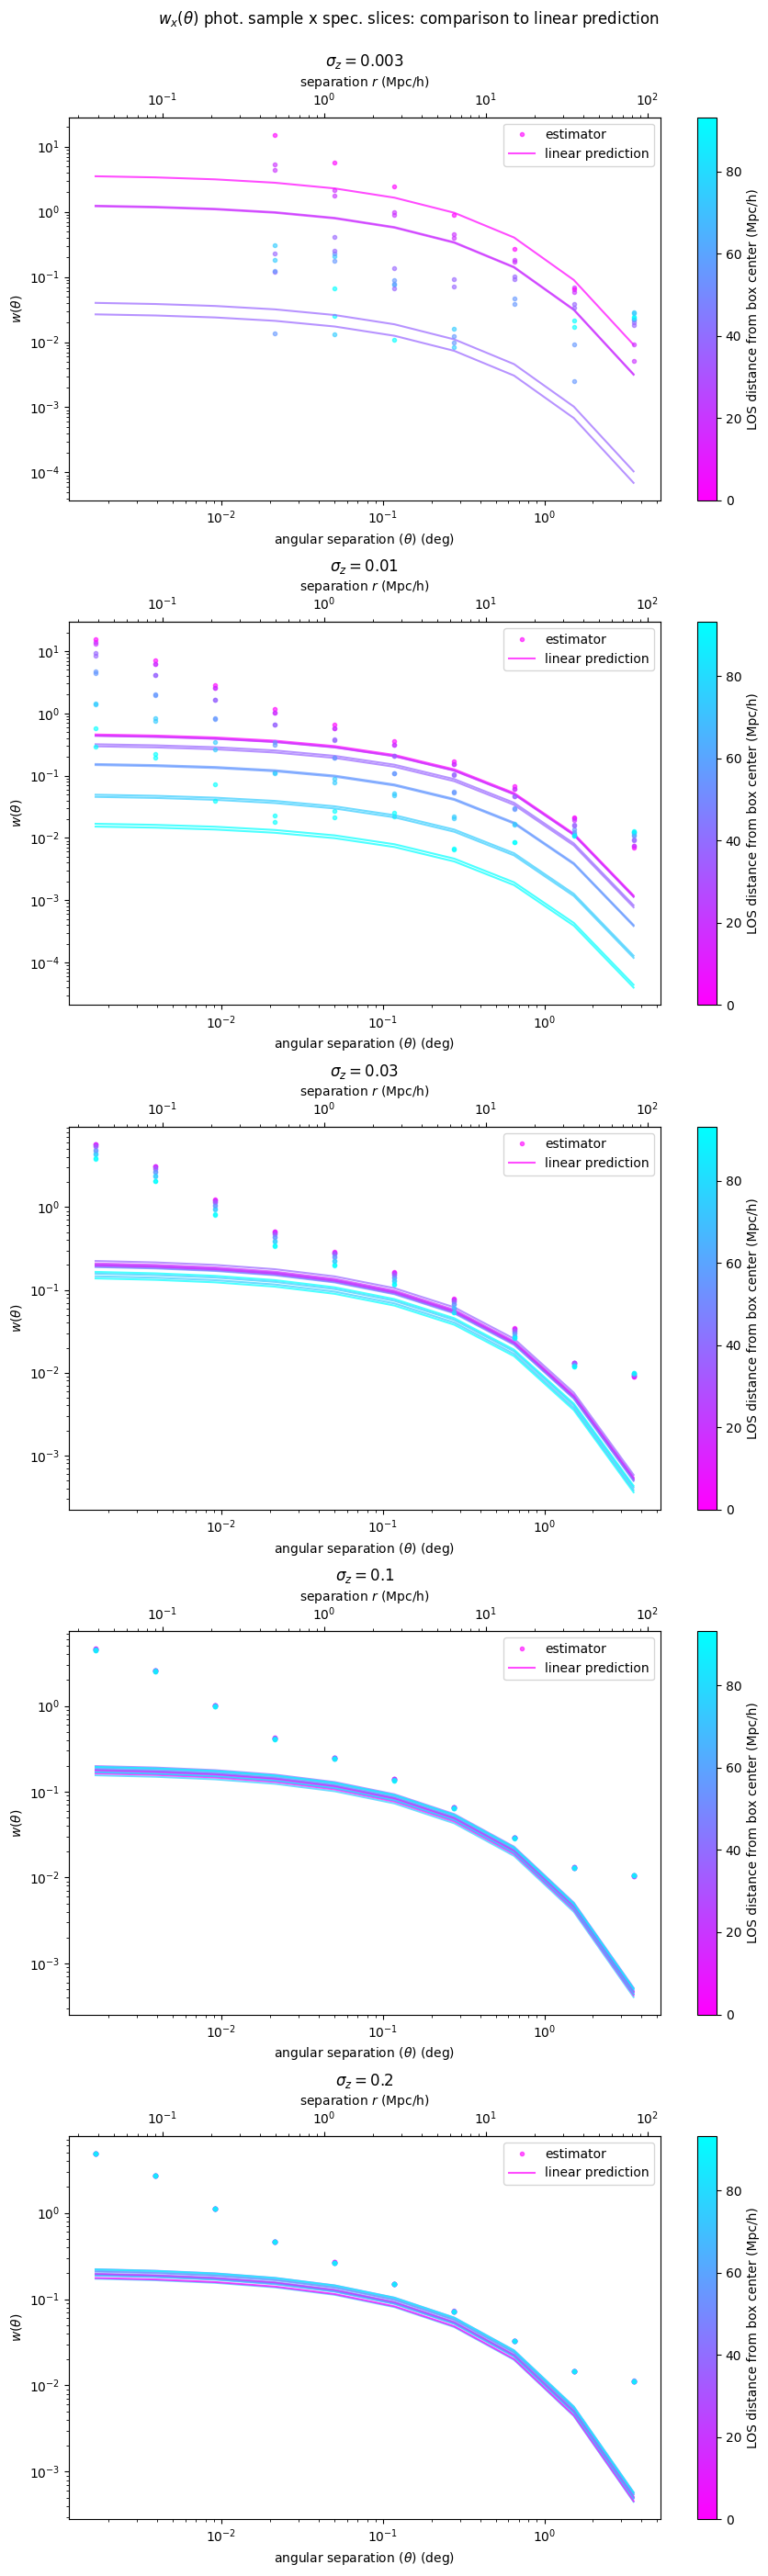

In [24]:
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(cmap='cool_r', norm=norm)

fig, axs = plt.subplots(5, 1, figsize=(9,28))

for i, xcorrs_ in enumerate(xcorrs):
    axs[i].set_title(f'$\sigma_z = $'f'{sigma_zs[i]}')
    for j, xcorr_slice in enumerate(xcorrs_):
        c = smap.to_rgba(np.abs(slice_centers[j]))
        label_data = f'estimator' if j==5 else ''
        label_pred = f'linear prediction' if j==5 else ''
        axs[i].plot(thetaavg, xcorr_slice, marker='.', ls='None', alpha=0.6, c=c, label=label_data)
        axs[i].plot(thetaavg, wlin_preds[i,j], ls='-', alpha=0.7, c=c, label=label_pred)

for ax in axs:
    ax.set_xlabel(r'angular separation ($\theta$) (deg)')
    ax.set_ylabel(r'$w(\theta)$')
    secax = ax.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
    secax.set_xlabel(r'separation $r$ (Mpc/h)')
    ax.loglog()
    ax.legend()
    fig.colorbar(smap, ax=ax, label='LOS distance from box center (Mpc/h)')
fig.suptitle(r'$w_x(\theta)$ phot. sample x spec. slices: comparison to linear prediction', y=1.)
fig.tight_layout()

Text(0.5, 1.2, '$w_x(\\theta)$ phot. sample x spec. slices: comparison to linear prediction')

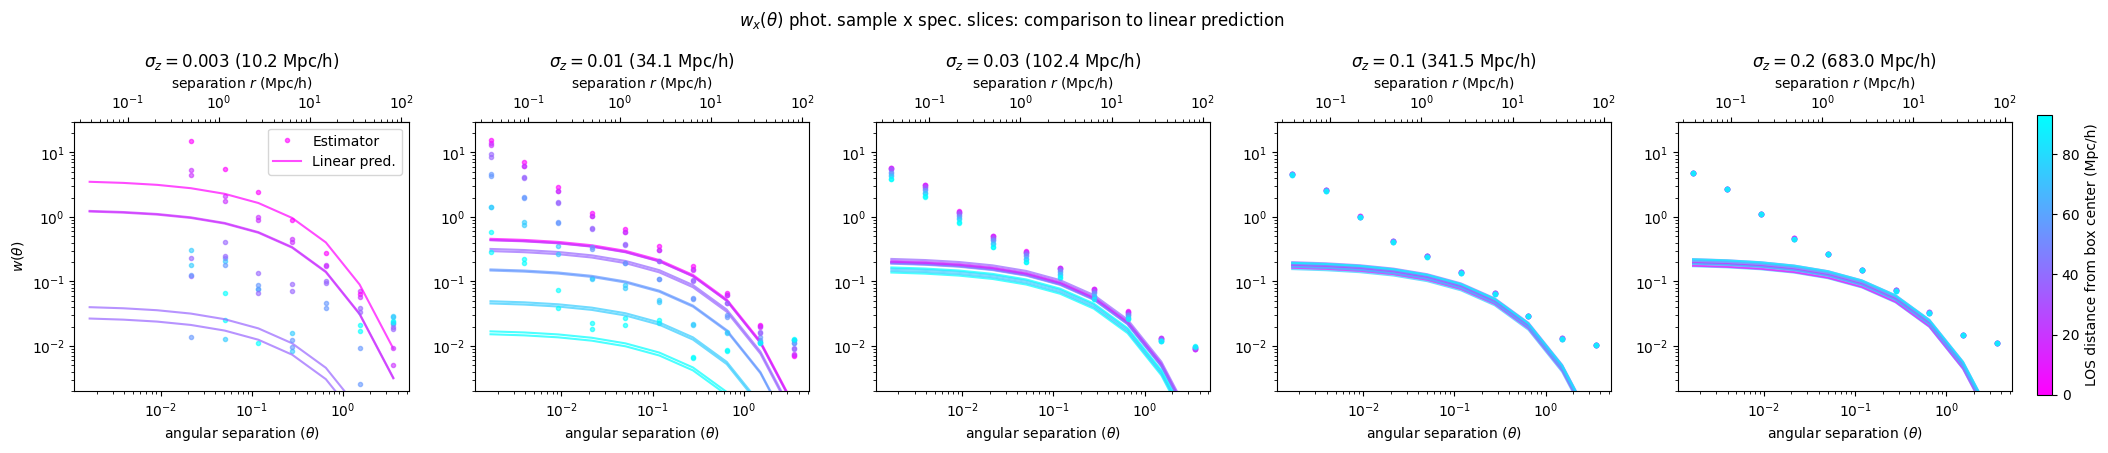

In [32]:
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(cmap='cool_r', norm=norm)

fig = plt.figure(figsize=(25,3.5))
axs = {}

for i, xcorrs_ in enumerate(xcorrs):
    axs[i] = fig.add_subplot(1,5,i+1)

    for j, xcorr_slice in enumerate(xcorrs_):
        c = smap.to_rgba(np.abs(slice_centers[j]))
        label_data = f'Estimator' if j==5 else ''
        label_pred = f'Linear pred.' if j==5 else ''
        axs[i].plot(thetaavg, xcorr_slice, marker='.', ls='None', alpha=0.6, c=c, label=label_data)
        axs[i].plot(thetaavg, wlin_preds[i,j], ls='-', alpha=0.7, c=c, label=label_pred)

    axs[i].set_xlabel(r'angular separation ($\theta$)')
    axs[i].set_ylim(2e-3,3e1)
    axs[i].loglog()
    secax = axs[i].secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
    secax.set_xlabel(r'separation $r$ (Mpc/h)')
    axs[i].set_title(r'$\sigma_z=$'+f'{sigma_zs[i]} ({dxs[i].value:.1f} Mpc/h)')

axs[0].legend()
axs[0].set_ylabel(r'$w(\theta)$')
cax = fig.add_axes([.91, 0.1, 0.006, 0.8])
fig.colorbar(smap, cax=cax, aspect=100, label='LOS distance from box center (Mpc/h)')
fig.suptitle(r'$w_x(\theta)$ phot. sample x spec. slices: comparison to linear prediction', y=1.2)
# fig.tight_layout()

/tmp/ipykernel_3916142/1587160986.py:12: RuntimeWarning: divide by zero encountered in divide
  axs[i].plot(thetaavg, xcorr_slice / wlin_preds[i,j], marker='.', ls='None', alpha=0.6, c=c)


Text(0.5, 1.2, '$w_x(\\theta)$ phot. sample x spec. slices: comparison to linear prediction')

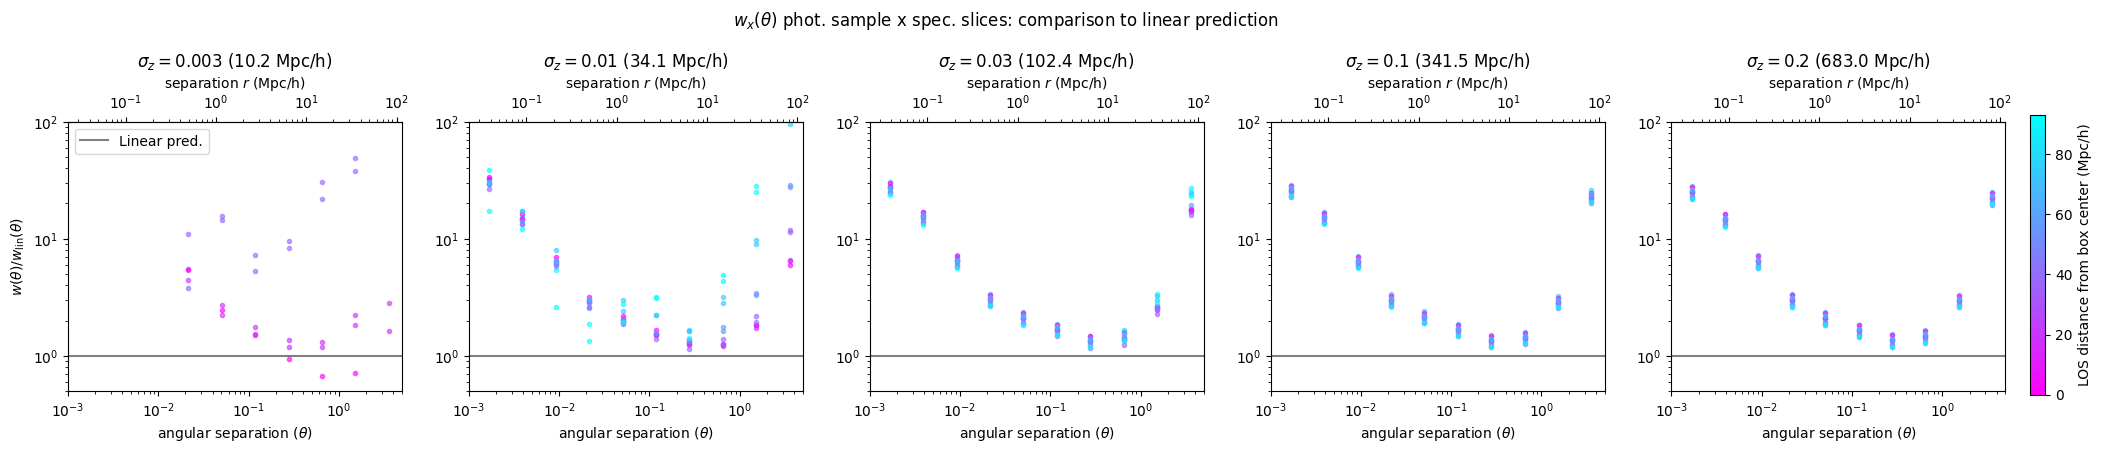

In [33]:
norm = mpl.colors.Normalize(vmin=0, vmax=max(slice_centers))
smap = mpl.cm.ScalarMappable(cmap='cool_r', norm=norm)

fig = plt.figure(figsize=(25,3.5))
axs = {}

for i, xcorrs_ in enumerate(xcorrs):
    axs[i] = fig.add_subplot(1,5,i+1)

    for j, xcorr_slice in enumerate(xcorrs_):
        c = smap.to_rgba(np.abs(slice_centers[j]))
        axs[i].plot(thetaavg, xcorr_slice / wlin_preds[i,j], marker='.', ls='None', alpha=0.6, c=c)

    axs[i].set_xlabel(r'angular separation ($\theta$)')
    axs[i].axhline(1, c='k', alpha=0.5, label='Linear pred.')
    axs[i].loglog()
    secax = axs[i].secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
    secax.set_xlabel(r'separation $r$ (Mpc/h)')
    axs[i].set_title(r'$\sigma_z=$'+f'{sigma_zs[i]} ({dxs[i].value:.1f} Mpc/h)')
    axs[i].set_xlim(1e-3, 5)
    axs[i].set_ylim(0.5, 1e2)
    
axs[0].set_ylabel(r'$w(\theta) / w_\mathrm{lin}(\theta)$')
axs[0].legend()
cax = fig.add_axes([.91, 0.1, 0.006, 0.8])
fig.colorbar(smap, cax=cax, aspect=100, label='LOS distance from box center (Mpc/h)')
fig.suptitle(r'$w_x(\theta)$ phot. sample x spec. slices: comparison to linear prediction', y=1.2)
# fig.tight_layout()